# Data Science Avancées

## <span style='color:green; font-weight: bold;'> Importation des modules, Variables globales, etc </span>

In [1]:
from pathlib import Path
from time import time
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.cm as cm


datasets_path = Path.cwd().parent.parent / "core" / "datasets" / "data"
print(datasets_path)

/home/godwin/Documents/Uparis/M1MLSD2223/ue_data2/data-science-avancees/core/datasets/data


## <span style='color:green; font-weight: bold;'>Chargement des données bbc</span>

In [2]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer=f'{datasets_path}/bbc.csv',
    usecols=['text', 'label']
)
df.head()

,text,label
0,England coach faces rap after row\n\nEngland c...,sport
1,Moody joins up with England\n\nLewis Moody has...,sport
2,Ferguson fears Milan cutting edge\n\nMancheste...,sport
3,Henry tipped for Fifa award\n\nFifa president ...,sport
4,Arnesen denies rift with Santini\n\nTottenham ...,sport


In [3]:
df_bbc = df.copy()
df_bbc.head()

,text,label
0,England coach faces rap after row\n\nEngland c...,sport
1,Moody joins up with England\n\nLewis Moody has...,sport
2,Ferguson fears Milan cutting edge\n\nMancheste...,sport
3,Henry tipped for Fifa award\n\nFifa president ...,sport
4,Arnesen denies rift with Santini\n\nTottenham ...,sport


In [4]:
labels = df_bbc['label'].unique()
labels

array(['sport', 'entertainment', 'tech', 'business', 'politics'],
      dtype=object)

In [5]:
list_unique_labels = list(df_bbc['label'].unique())
list_unique_labels

['sport', 'entertainment', 'tech', 'business', 'politics']

## <span style='color:green; font-weight: bold;'>Analyse exploratoire des données</span>

In [6]:
# Y-a-t'il des reviews vides?
df_bbc['text'].isnull().sum()

0

In [7]:
from collections import Counter

def target2counts(df_doc: pd.DataFrame) -> {str: int}:
    """
    Count number of document per label
    :param df_doc:
    :return:
    """
    targets = list(df_doc.label)
    target_counter = Counter(targets)  # -> dico
    return target_counter

target2counts(df_bbc)

Counter({'sport': 511,
         'business': 510,
         'politics': 417,
         'tech': 401,
         'entertainment': 386})

In [8]:
# Combien de mots dans chaque review ?
word_counts = df_bbc['text'].apply(lambda x: len(x.split())) # pd.series
word_counts.describe()

count    2225.000000
mean      384.040449
std       238.174497
min        89.000000
25%       246.000000
50%       332.000000
75%       471.000000
max      4432.000000
Name: text, dtype: float64

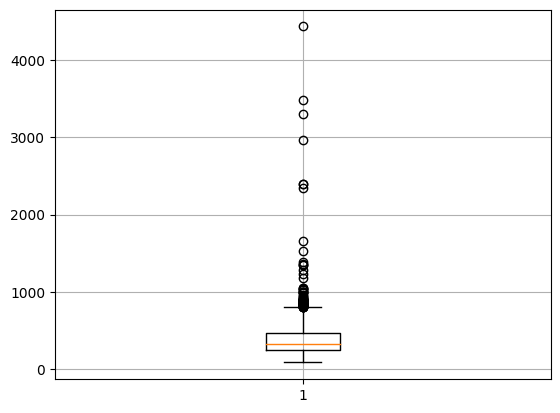

In [9]:
_ = plt.boxplot(word_counts.values)
plt.grid(True)
plt.show()

# NB :
# La plupart des reviews ont entre 250 et 475 mots

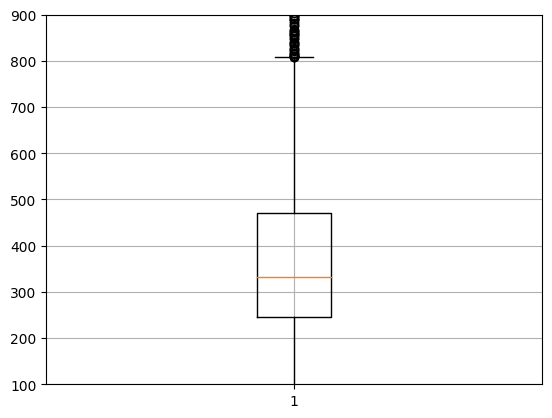

In [10]:
_ = plt.boxplot(word_counts.values)
plt.ylim(100, 900)
plt.grid(True)
plt.show()

## <span style='color:green; font-weight: bold;'>Nettoyage des données textuelles</span>

On enchaîne dans la fonction *data_preprocessing* les méthodes de nettoyage classiques vues précédemment.

* suppression des tag HTML
* conservation des mots uniquement
* passage en minuscule
* *(tokenization)*
* lemmatisation
* *(réassemblage des reviews)*

In [11]:
from core.preprocessing import Corpus

[nltk_data] Downloading package punkt to /home/godwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/godwin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/godwin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/godwin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
cp = Corpus()
df_bbc = cp.process_documents(df_bbc)

In [13]:
df_bbc.head()

,text,label
0,england coach face rap row england coach andy ...,sport
1,moody join england lewis moody flown dublin jo...,sport
2,ferguson fear milan cutting edge manchester un...,sport
3,henry tipped fifa award fifa president sepp bl...,sport
4,arnesen denies rift santini tottenham sporting...,sport


## <span style='color:green; font-weight: bold;'>Représentation vectorielle de données textuelles</span>

Dans cette partie, nous souhaitons représenter notre corpus de documents en matrice document-terme $\mathbf{X}$ de taille $N\times V$, $N$ étant le nombre de documents et $V$ le nombre total de mots présents dans le vocabulaire. Exemple avec $N=2$ et $V=9$ :
<img src="https://drive.google.com/uc?id=1jdz0lyVCH-7ZfxC5dpj_34f34rBWKs52" width=700>

### 1_ère approche: Bag-Of-Words (BOW)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(min_df=10)
X_docs_bow = bow_vectorizer.fit_transform(df_bbc['text'])
print('X_docs_bow shape: ', X_docs_bow.shape)

# NB:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

X_docs_bow shape:  (2225, 5167)


In [15]:
from numpy import count_nonzero

nb_nonZero = count_nonzero(X_docs_bow.todense())
my_size = float(X_docs_bow.todense().size)
print("Nombre d'éléments non nuls : ", nb_nonZero)
print("Nombre d'éléments : ", my_size)
print("Sparsité : ", 1-(nb_nonZero/my_size))

# NB:
# On a une matrice très sparse!

Nombre d'éléments non nuls :  290076
Nombre d'éléments :  11496575.0
Sparsité :  0.9747684853967378


### 2_ème approche: Pondération matrice *documents x termes* par TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5, # ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5)
    min_df=5,   # ignoring terms that are not present in at least 5 documents (set by min_df=5)
    stop_words="english",
)
t0 = time()
X_docs_tfidf = tfidf_vectorizer.fit_transform(df_bbc['text'])
print('X_docs_bow shape: ', X_docs_tfidf.shape)
print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_docs_tfidf.shape[0]}, n_features: {X_docs_tfidf.shape[1]}")

X_docs_bow shape:  (2225, 8108)
vectorization done in 0.397 s
n_samples: 2225, n_features: 8108


In [17]:
from numpy import count_nonzero

nb_nonZero = count_nonzero(X_docs_tfidf.todense())
my_size = float(X_docs_tfidf.todense().size)
print("Nombre d'éléments non nuls : ", nb_nonZero)
print("Nombre d'éléments : ", my_size)
print("Sparsité : ", 1-(nb_nonZero/my_size))

# NB:
# On a une matrice très sparse!

Nombre d'éléments non nuls :  274668
Nombre d'éléments :  18040300.0
Sparsité :  0.9847747543000948


### 3_ème approche: Word embedding

In [18]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [19]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

#### <span style='color:#3390FF; font-weight: bold;'>Word2Vec representation of words</span>

In [20]:
# from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec

Exécuter les sections suivantes si vous n'avez pas encore chargé et sauvegardé les vectors dans le model dédié

In [21]:
# 2nd alternative
word2vec_file = f'{datasets_path}/../glove.840B.300d.txt'
# we could load keyed vector by specifying that there is no header (dim shape) on top of file.
words_vectors_from_text = KeyedVectors.load_word2vec_format(word2vec_file, binary=False, no_header=True)

# 1st way
# load keyed vector build by own
# word2vec_file = f'{datasets_path}/../glove_model2.txt'
# word2vec_trained_model = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)


# 3rd alt: only if we store data on gensim site_package folder
# words_vectors_from_text = KeyedVectors.load_word2vec_format(datapath('glove.840B.300d.txt'), binary=False, no_header=True)

INFO - 23:46:08: loading projection weights from /home/godwin/Documents/Uparis/M1MLSD2223/ue_data2/data-science-avancees/core/datasets/data/../glove.840B.300d.txt
WARNING - 23:46:34: duplicate word '����������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������' in word2vec file, ignoring all but first
INFO - 23:51:19: KeyedVectors lifecycle event {'msg': 'loaded (2196017, 300) matrix of type float32 from /home/godwin/Documents/Uparis/M1MLSD2223/ue_data2/data-science-avancees/core/datasets/data/../glove.840B.300d.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-05-05T23:51:19.690299', 'gensim': '4.3.1', 'python': '3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]', 'platform': 'Linux-5.15.0-71-generic-x86_6

In [22]:
# sauvegarder le model pour une reproductibilité
words_vectors_from_text.save('word2vec.wordvectors')

INFO - 23:55:11: KeyedVectors lifecycle event {'fname_or_handle': 'word2vec.wordvectors', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-05-05T23:55:11.811449', 'gensim': '4.3.1', 'python': '3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]', 'platform': 'Linux-5.15.0-71-generic-x86_64-with-glibc2.31', 'event': 'saving'}
INFO - 23:55:11: storing np array 'vectors' to word2vec.wordvectors.vectors.npy
INFO - 23:55:21: saved word2vec.wordvectors


In [23]:
# charger les vecteurs depuis la projection mémoire, partagée par les processus
words_vectors_from_mapping = KeyedVectors.load('word2vec.wordvectors', mmap='r')
print(words_vectors_from_mapping)

INFO - 23:55:36: loading KeyedVectors object from word2vec.wordvectors
INFO - 23:55:38: loading vectors from word2vec.wordvectors.vectors.npy with mmap=r
INFO - 23:55:38: KeyedVectors lifecycle event {'fname': 'word2vec.wordvectors', 'datetime': '2023-05-05T23:55:38.504651', 'gensim': '4.3.1', 'python': '3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]', 'platform': 'Linux-5.15.0-71-generic-x86_64-with-glibc2.31', 'event': 'loaded'}


KeyedVectors<vector_size=300, 2196017 keys>


In [24]:
# Finding similar words
# The most_similar() function finds the cosine similarity of the given word with 
# other words using the word2Vec representations of each word
result = words_vectors_from_mapping.most_similar('king', topn=5)
result

/home/godwin/.cache/pypoetry/virtualenvs/dsa-MQpLTWhO-py3.10/lib/python3.10/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


[('kings', 0.7876613736152649),
 ('prince', 0.7337737083435059),
 ('queen', 0.7252609729766846),
 ('King', 0.710679292678833),
 ('throne', 0.6726004481315613)]

In [25]:
# Calculons: (king - man) + woman = ?
result = words_vectors_from_mapping.most_similar(
    positive=['woman', 'king'],
    negative=['man'],
    topn=1
)
result

[('queen', 0.775162398815155)]

In [26]:
# voir la taille d'un vecteur de mot
words_vectors_from_mapping['hello'].shape
# model['hello']

(300,)

In [27]:
'hello' in words_vectors_from_mapping.key_to_index.keys()

True

In [28]:
computer_vector = words_vectors_from_mapping['computer']  # Get numpy vector of a word
computer_vector

memmap([-0.26657  , -0.13717  ,  0.23549  , -0.26712  ,  0.093324 ,
         0.17563  , -0.33309  , -0.81744  ,  0.52655  ,  1.588    ,
         0.078138 , -0.093094 , -0.27167  , -0.31207  , -0.35018  ,
         0.072898 ,  0.032007 ,  2.5085   , -0.35727  , -0.018104 ,
         0.26102  , -0.3157   , -0.46466  ,  0.029905 ,  0.576    ,
        -0.34603  , -0.1502   , -0.23481  ,  0.20626  ,  0.28202  ,
        -0.6897   , -0.17632  ,  0.40369  ,  0.40672  ,  0.13068  ,
        -0.059988 , -0.3405   ,  0.46314  , -0.21149  ,  0.033152 ,
         0.36526  ,  0.049521 , -0.096128 , -0.087093 , -0.12957  ,
         0.22673  , -0.50435  , -0.50732  ,  0.27695  ,  0.14523  ,
        -0.11455  , -0.13968  ,  0.38549  ,  0.26088  , -0.43217  ,
        -0.45305  ,  0.072362 , -0.53383  ,  0.23317  ,  0.10471  ,
         0.51278  , -0.05899  ,  0.06051  ,  0.22083  ,  0.63098  ,
        -0.03232  , -0.36192  ,  0.45576  ,  0.037796 ,  0.21651  ,
         0.44988  , -0.33074  ,  0.32553  , -0.3

Nous allons maintenant récupérer la représentation des mots du modèle

In [29]:
# import sys
# sys.path.insert(0,"..")

In [30]:
from core.word_embedding import Word2VecVectorizer

# Set a word2vec vectorizer
vectorizer = Word2VecVectorizer(model=words_vectors_from_mapping)
# Get the sentence embeddings for the train dataset
X_w2v = vectorizer.fit_transform(df_bbc['text'])
print('X_w2v shape: ', X_w2v.shape)

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 2225
X_w2v shape:  (2225, 300)


#### <span style='color:#3390FF; font-weight: bold;'>GloVe representation of words</span>

Exécuter les sections suivantes si vous n'avez pas encore chargé et sauvegardé les vectors dans le model dédié

###### load glove vector into gensim object

In [31]:
glove_file = f'{datasets_path}/../glove.840B.300d.txt'

# we could load keyed vector by specifying that
# there is no header (dim shape) on top of file.

glove_words_vectors_from_text = KeyedVectors.load_word2vec_format(
    fname=glove_file,
    binary=False,
    no_header=True
)

# sauvegarder les vecteurs de l'objet gensim dans un fichier
# ---
glove_words_vectors_from_text.save('glove.wordvectors')

# load
# ---
glove_words_vectors_from_mapping = KeyedVectors.load('glove.wordvectors', mmap='r')
# print(glove_words_vectors_from_mapping)

INFO - 18:41:07: loading projection weights from /home/godwin/Documents/Uparis/M1MLSD2223/ue_data2/data-science-avancees/core/datasets/data/../glove.840B.300d.txt
WARNING - 18:41:33: duplicate word '����������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������' in word2vec file, ignoring all but first
INFO - 18:45:24: KeyedVectors lifecycle event {'msg': 'loaded (2196017, 300) matrix of type float32 from /home/godwin/Documents/Uparis/M1MLSD2223/ue_data2/data-science-avancees/core/datasets/data/../glove.840B.300d.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-05-05T18:45:24.797915', 'gensim': '4.3.1', 'python': '3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]', 'platform': 'Linux-5.15.0-71-generic-x86_6

###### load gensim object from file

In [32]:
# updated/new way to do that

# glove_file = f'{datasets_path}/../glove.840B.300d.txt'
# glove_trained_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

###### save glove object into output file

In [33]:
# deprecated way

#(_,_) = glove2word2vec(
#    glove_input_file=word2vec_file,
#    word2vec_output_file=tmp_file
#)

Nous allons maintenant récupérer la représentation des mots du modèle

In [34]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model=glove_words_vectors_from_mapping)
# Get the sentence embeddings for the train dataset
X_glove = vectorizer.fit_transform(df_bbc['text'])
print('X_glove shape: ', X_glove.shape)

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 2225
X_glove shape:  (2225, 300)


# <span style='color:green; font-weight: bold;'>Visualisation through Dimensionality Reduction</span>

In [135]:
from core.plot import points

In [36]:
topics = df_bbc['label'].unique()
color_mapping = {topic: i for i, topic in enumerate(topics)}
topic_colors = [color_mapping[topic] for topic in df_bbc['label']]

## Bac-Of-Words X-matrix
---

### Principal Component Analysis 

In [37]:
from sklearn.decomposition import PCA # ne supporte pas la sparcité

l' ACP ne supporte pas les matrices très sparces

In [38]:
# 
# >> pca = PCA(n_components=2)
# >> result = pca.fit_transform(X_docs_bow)

# Scatter plot de la projection
# pyplot.scatter(result[:, 0], result[:, 1])
# dico_terms_idx = result.vocabulary_
# for i, word in enumerate(words):
# 	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
# pyplot.show()

# NB:
# Il est difficile de tirer beaucoup de sens de ce graphique avec un 
# corpus aussi minuscule...

Nous allons trouver un autre alternative qui est la technique de dimensionnalité **LSA** connu sous le nom de **TruncatedSVD**

### LSA (aka TruncatedSVD)

In [39]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [40]:
# la svd fait une décomposition sans normalisation. 
# nous allons effectuer une normalisation pour optimiser les résultats
n_components = 5
lsa = make_pipeline(
    TruncatedSVD(
        n_components=n_components,
        n_iter=2500,
        random_state=123
    )
    ,
    Normalizer(copy=False)
)

t0 = time()
X_docs_bow_red_lsa = lsa.fit_transform(X_docs_bow)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 45.810 s
Explained variance of the SVD step: 12.9%


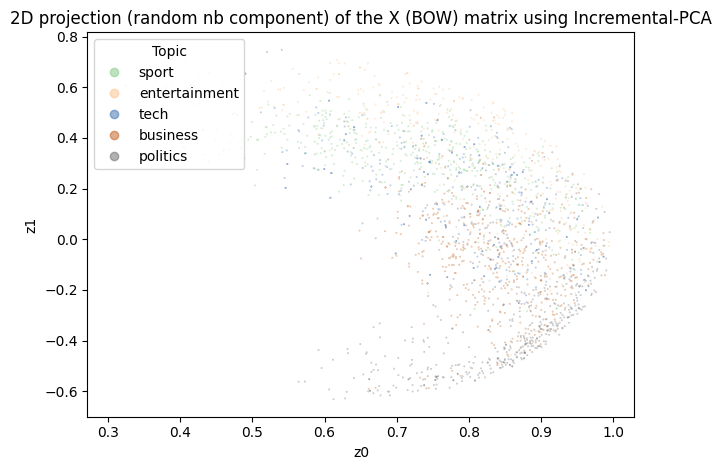

In [41]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_bow_red_lsa[:, nth_dims[0]],
    y=X_docs_bow_red_lsa[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb component) of the X (BOW) matrix using Incremental-PCA'
)

Nous allons tenter d'explorer un peu les résultats, en cherchant nombre d'axes factoriels, nous permettant de préserver un certains ```%centage``` de variance de nos données, dans un but purement représentative.

In [42]:
# la dimension fitté par le modèle
lsa2 = TruncatedSVD()
lsa2.fit(X_docs_bow)
cumsum2 = np.cumsum(lsa2.explained_variance_ratio_)
d = np.argmax(cumsum2 >= 0.95) + 1  # d equals 1
d

1

la matrice étant très sparce, il ne faut qu'1 seul dimension, on va essayer de confirmer ce résulat via le graphique en ```coude```


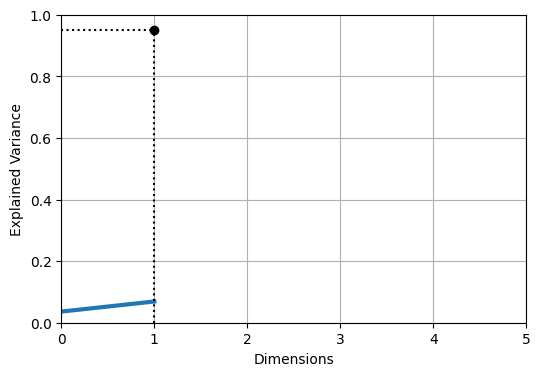

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum2, linewidth=3)
plt.axis([0, 5, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(10, 0.1), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

#### $\rightarrow$ vers une approche ICPA

Etant donné que l'on a une matrice très sparse, nous allons explorer une autre approche de PCA qui nous permettra de faire en même temps du PCA, de l'imputation. En d'autre terme, nous ferons une imputation à l'aide du PCA 

### Incremental PCA

In [44]:
from sklearn.decomposition import IncrementalPCA

# choix arbitraire
n_components = 2
ipca = IncrementalPCA(
    n_components=n_components,
    batch_size=100
)

X_docs_bow_red_ipca = ipca.fit_transform(X_docs_bow)

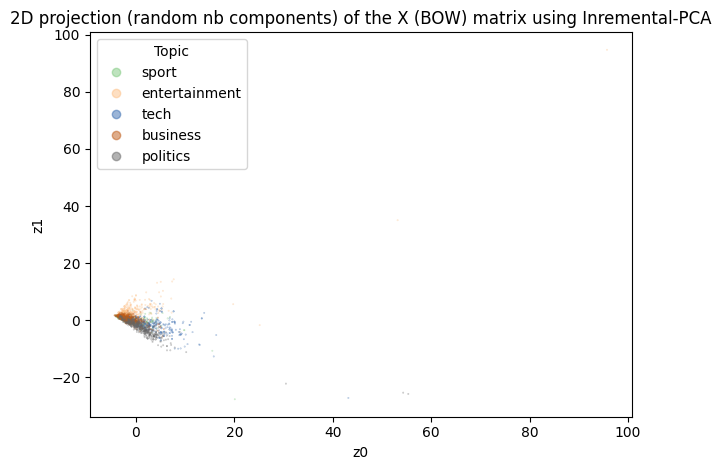

In [45]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_bow_red_ipca[:, nth_dims[0]],
    y=X_docs_bow_red_ipca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (BOW) matrix using Inremental-PCA'
)

In [46]:
# nombre de composant principal fitté par le model 
inc_pca = IncrementalPCA()
inc_pca.fit(X_docs_bow)
inc_pca.n_components_

2225

In [47]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
inc_pca_ck = IncrementalPCA()
inc_pca_ck.fit(X_docs_bow)
inc_pca_ck_cumsum = np.cumsum(inc_pca_ck.explained_variance_ratio_)
inc_pca_ck_d = np.argmax(inc_pca_ck_cumsum >= 0.95) + 1
inc_pca_ck_d

1065

Essayons de confirmer notre intuition via la méthode ou le graphique du **coude** .

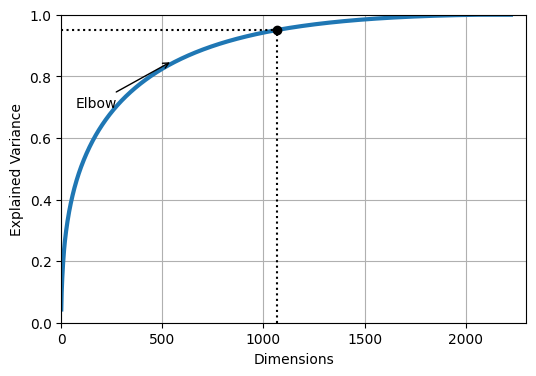

In [48]:
plt.figure(figsize=(6, 4))
plt.plot(inc_pca_ck_cumsum, linewidth=3)
plt.axis([0, 2300, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([inc_pca_ck_d, inc_pca_ck_d], [0, 0.95], "k:")
plt.plot([0, inc_pca_ck_d], [0.95, 0.95], "k:")
plt.plot(inc_pca_ck_d, 0.95, "ko")
plt.annotate("Elbow", xy=(550, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [49]:
# refaisons la projection
inc_pca_ck2 = IncrementalPCA(
    n_components=inc_pca_ck_d,
    batch_size=1500
)
X_docs_bow_red_inc_pca_ck = inc_pca_ck2.fit_transform(X_docs_bow)

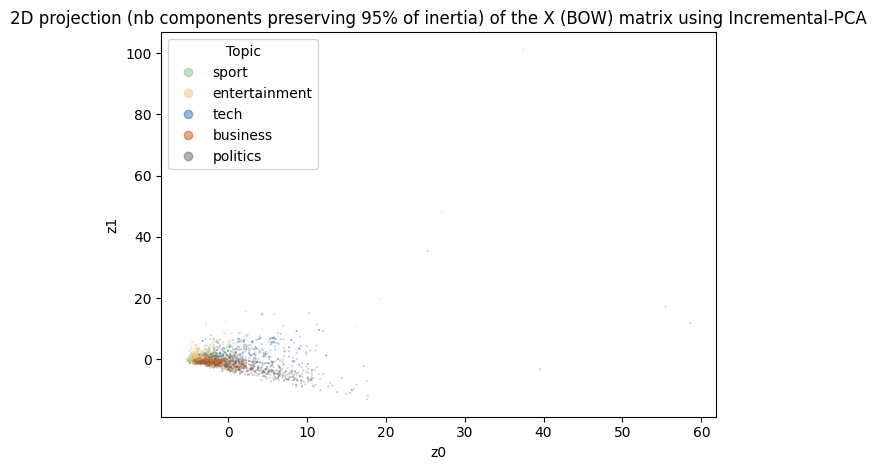

In [50]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_bow_red_inc_pca_ck[:, nth_dims[0]],
    y=X_docs_bow_red_inc_pca_ck[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (nb components preserving 95% of inertia) of the X (BOW) matrix using Incremental-PCA'
)

### Document embedding using UMAP

In [51]:
import umap.plot
import umap
# umap.plot requires pandas matplotlib datashader bokeh holoviews scikit-image and colorcet to be installed

/home/godwin/.cache/pypoetry/virtualenvs/dsa-MQpLTWhO-py3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/godwin/.cache/pypoetry/virtualenvs/dsa-MQpLTWhO-py3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/godwin/.cach

In [52]:
%%time
X_docs_bow_umap_embedding = umap.UMAP(
    n_components=2,
    metric='hellinger'
).fit(X_docs_bow)
X_docs_bow_umap_embedding.embedding_.shape

CPU times: user 31.3 s, sys: 710 ms, total: 32.1 s
Wall time: 21 s


(2225, 2)

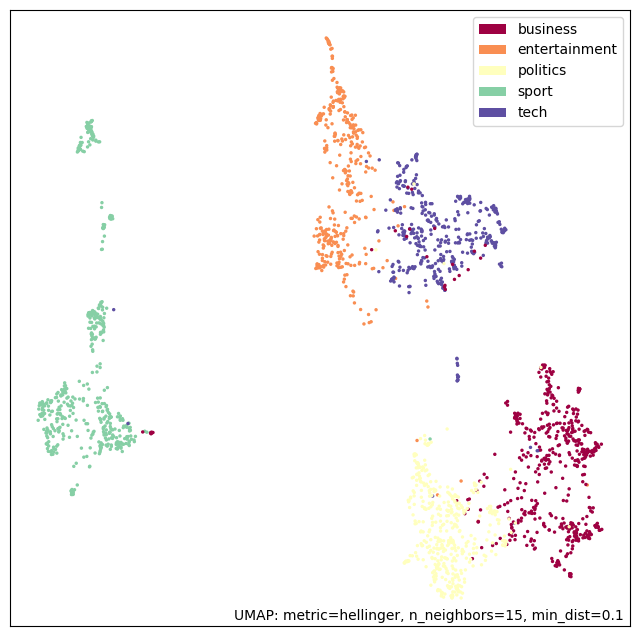

In [53]:
# For interactive plotting use
# f = umap.plot.interactive(embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
# show(f)
f = umap.plot.points(X_docs_bow_umap_embedding, labels=df_bbc['label'])

## TF-IDF X-matrix
---

In [54]:
#### La matrice reste sparce, et on ne peut pas appliquer le PCA

#### LSA (aka TruncatedSVD)

In [55]:
# la svd fait une décomposition sans normalisation. 
# nous allons effectuer une normalisation pour optimiser les résultats

n_components=1065  # after fitting
lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
t0 = time()
X_docs_tfidf_red_lsa = lsa.fit_transform(X_docs_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 13.195 s
Explained variance of the SVD step: 86.1%


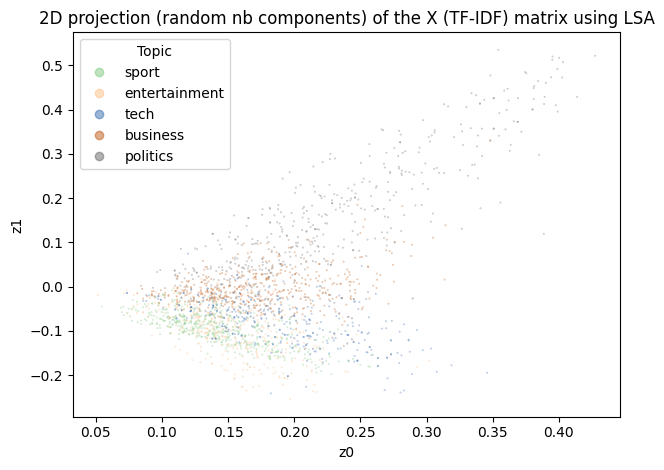

In [56]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_tfidf_red_lsa[:, nth_dims[0]],
    y=X_docs_tfidf_red_lsa[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (TF-IDF) matrix using LSA'
)

Nous allons tenter d'explorer un peu les résultats, en cherchant nombre d'axes factoriels, nous permettant de préserver le plus de variance de nos données, dans un but purement représentative.

In [57]:
# la dimension fitté par le modèle
lsa2_tfidf = TruncatedSVD()
lsa2_tfidf.fit(X_docs_tfidf)
cumsum2_tfidf = np.cumsum(lsa2_tfidf.explained_variance_ratio_)
d = np.argmax(cumsum2_tfidf >= 0.95) + 1  # d equals XXX
d

1

la matrice étant très sparce, il ne faut qu'1 seul dimension, on va essayer de confirmer ce résulat via le graphique en ```coude```


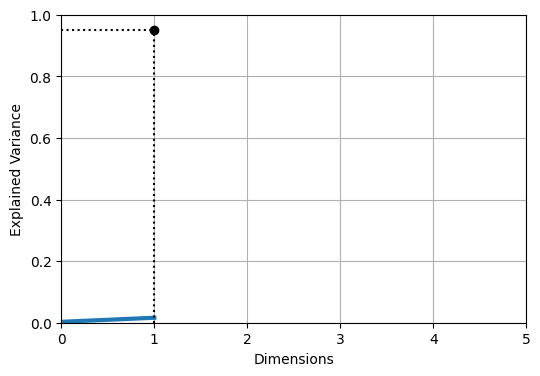

In [58]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum2_tfidf, linewidth=3)
plt.axis([0, 5, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(10, 0.1), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

#### $\rightarrow$ vers une approche ICPAholoviews

Etant donné que l'on a une matrice très sparse, nous allons explorer une autre approche de PCA qui nous permettra de faire en même temps du PCA, de l'imputation. En d'autre terme, nous ferons une imputation à l'aide du PCA 

#### Incremental PCA

In [59]:
from sklearn.decomposition import IncrementalPCA


# choix arbitraire
n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=100)
X_docs_tfidf_red_ipca = ipca.fit_transform(X_docs_tfidf)

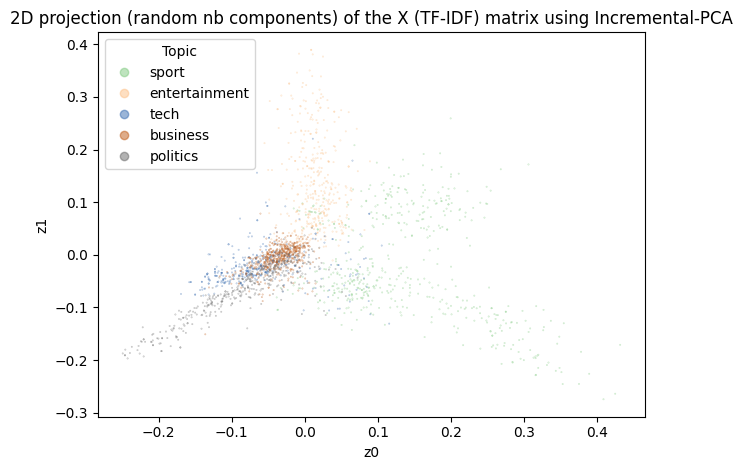

In [63]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_tfidf_red_ipca[:, nth_dims[0]],
    y=X_docs_tfidf_red_ipca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (TF-IDF) matrix using Incremental-PCA'
)

In [64]:
# nombre de composant principal fitté par le model 
inc_pca_tfidf = IncrementalPCA()
inc_pca_tfidf.fit(X_docs_tfidf)
inc_pca_tfidf.n_components_

2225

In [65]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
inc_pca_tfidf_ck = IncrementalPCA()
inc_pca_tfidf_ck.fit(X_docs_tfidf)
inc_pca_tfidf_ck_cumsum = np.cumsum(inc_pca_ck.explained_variance_ratio_)
inc_pca_tfidf_ck_d = np.argmax(inc_pca_ck_cumsum >= 0.95) + 1
inc_pca_tfidf_ck_d

1065

Confirmons notre intuition à partir d'un graphique 

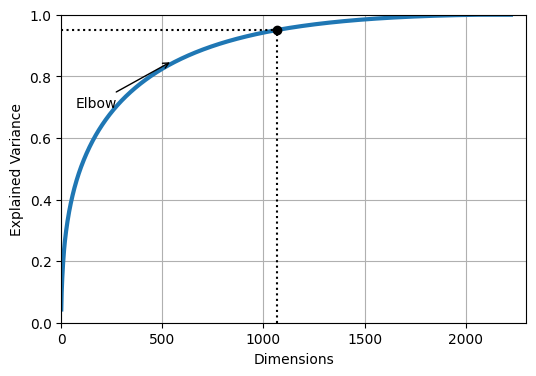

In [66]:
plt.figure(figsize=(6, 4))
plt.plot(inc_pca_tfidf_ck_cumsum, linewidth=3)
plt.axis([0, 2300, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([inc_pca_tfidf_ck_d, inc_pca_tfidf_ck_d], [0, 0.95], "k:")
plt.plot([0, inc_pca_tfidf_ck_d], [0.95, 0.95], "k:")
plt.plot(inc_pca_tfidf_ck_d, 0.95, "ko")
plt.annotate("Elbow", xy=(550, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [67]:
X_docs_tfidf.shape

(2225, 8108)

In [68]:
# refaisons la projection
inc_pca_tfidf_new = IncrementalPCA(
    n_components=inc_pca_ck_d,
    batch_size=1500
)
X_docs_tfidf_red_inc_pca_new = inc_pca_tfidf_new.fit_transform(X_docs_tfidf)
print('X_docs_tfidf_red_inc_pca_new: ', X_docs_tfidf_red_inc_pca_new.shape)

X_docs_tfidf_red_inc_pca_new:  (2225, 1065)


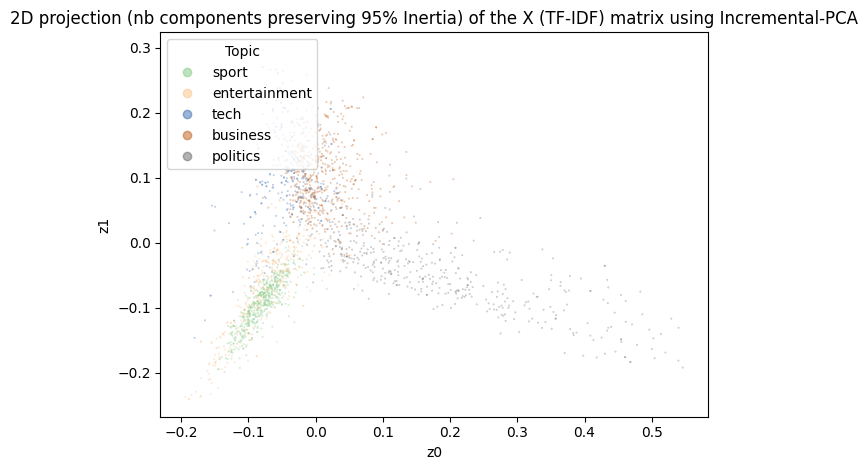

In [69]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_tfidf_red_inc_pca_new[:, nth_dims[0]],
    y=X_docs_tfidf_red_inc_pca_new[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (nb components preserving 95% Inertia) of the X (TF-IDF) matrix using Incremental-PCA'
)

### Document embedding using UMAP

In [70]:
%%time
X_docs_tfidf_umap_embedding = umap.UMAP(metric='hellinger').fit(X_docs_tfidf)


CPU times: user 30.1 s, sys: 748 ms, total: 30.8 s
Wall time: 19.3 s


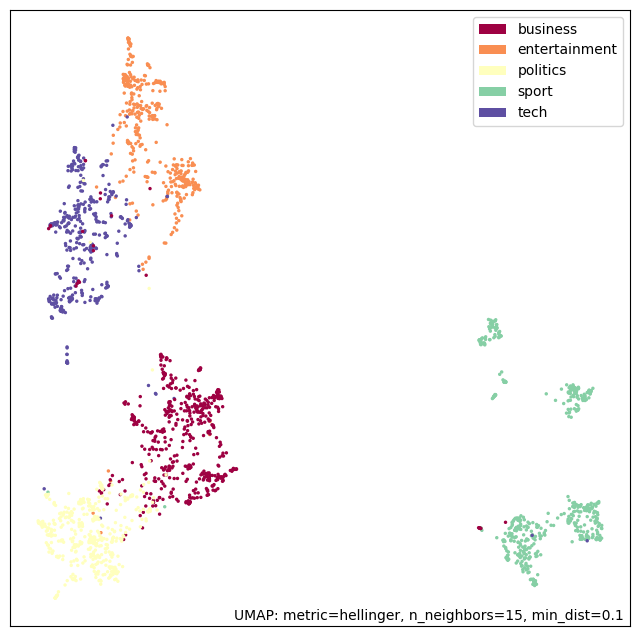

In [71]:
# For interactive plotting use
# fig = umap.plot.interactive(tfidf_embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
# show(fig)
_ = umap.plot.points(X_docs_tfidf_umap_embedding, labels=df_bbc['label'])

## <span style='color:#3390FF; font-weight: bold;'>Word2Vec representation of words</span>
---

### Principal Component Analysis (PCA)

In [72]:
# choix arbitraire
n_components = 2
pca = PCA(n_components=n_components)
X_w2v_pca = pca.fit_transform(X_w2v)

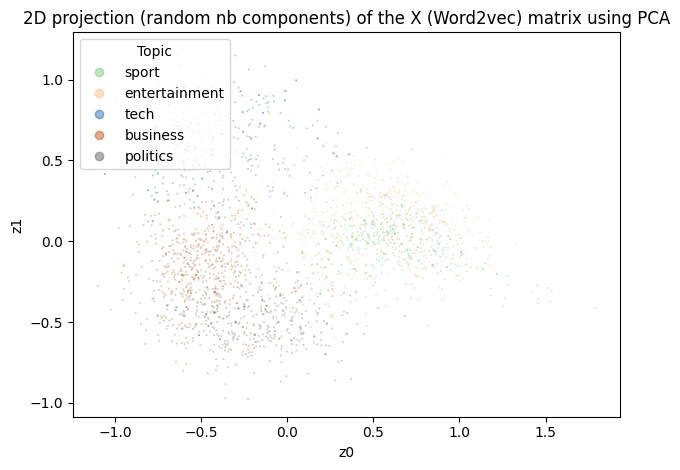

In [73]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_w2v_pca[:, nth_dims[0]],
    y=X_w2v_pca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2vec) matrix using PCA'
)

In [74]:
# nombre de composant principal fitté par le model 
pca_w2v2 = PCA()
pca_w2v2.fit(X_w2v)
pca_w2v2.n_components_

300

On peut constater que les données la projection des données ne réduit pas la dimension de ces dernier. Celà indique que les données sont bien représenter dans l'espace vectoriel.

Cela dit, voyons quel nombre de dimension serait le plus adapter pour grader ```95% d'intertie``` de notre jeu de données

In [75]:
# checker combien d'axe factoriel faut-il pour préserver 95% d'inertie de nos jeux de données
pca_w2v2_ck = PCA()
pca_w2v2_ck.fit(X_w2v)
pca_w2v2_ck_cumsum = np.cumsum(pca_w2v2_ck.explained_variance_ratio_)
pca_w2v2_ck_d = np.argmax(pca_w2v2_ck_cumsum >= 0.95) + 1
pca_w2v2_ck_d # d=130


130

### Manifold learning

#### $\rightarrow$ vers une approche t-SNE

Nous pouvons tracer les embeddings dans un **espace bidimensionnel** qui peut nous montrer comment les mots sont liés. Les mots les plus **similaires** devraient être représentés **en groupes**, tandis que les mots non apparentés apparaîtront à une grande distance. <br><br>

Cela nécessite une technique de **réduction de dimension** supplémentaire pour ramener les dimensions à 2 ou 3. La technique de réduction la plus populaire est elle-même une méthode d'embedding: **t-Distributed Stochastic Neighbor Embedding (t-SNE)**.

t-SNE est une technique de réduction de la dimensionnalité qui convient parfaitement à la visualisation d'ensembles de données de grande dimension. Il s'agit d'une technique d'apprentissage de type **manifold**, ce qui signifie qu'il tente de faire **correspondre des données de haute dimension à un manifold de plus faible dimension**, créant ainsi un embedding qui tente de maintenir la structure locale des données. Elle est presque exclusivement utilisée pour la visualisation car la sortie est stochastique et elle ne prend pas en charge la transformation de nouvelles données.

In [76]:
from sklearn.manifold import TSNE                   # final reduction

#### t-Distributed Sémantic Neighbord Embedding (t-SNE)

In [77]:
tsne = TSNE(
    perplexity=40,
    n_components=2,
    init='pca',
    n_iter=2500,
    random_state=123
)
z = tsne.fit_transform(X_w2v)

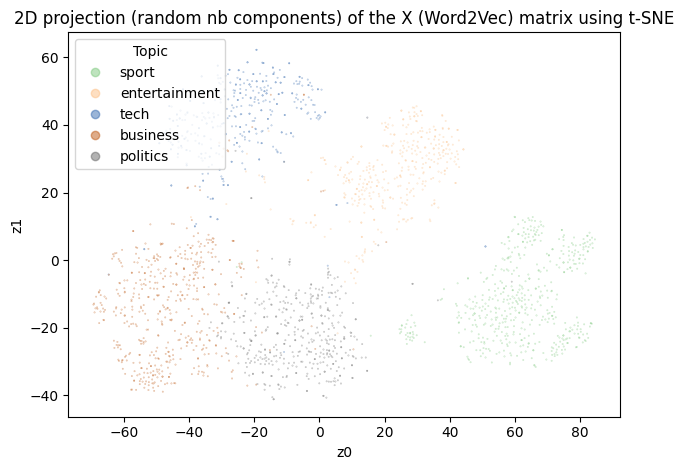

In [78]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=z[:, nth_dims[0]],
    y=z[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2Vec) matrix using t-SNE'
)

### Locally Linear Embedding (LLE)

In [79]:
n_neighbors = 100  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

In [80]:
from sklearn import manifold

In [81]:
lle_params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "dense",
    "random_state": 123,
}

lle_standard = manifold.LocallyLinearEmbedding(method="standard", **lle_params)
X_w2v_standard_unrolled = lle_standard.fit_transform(X_w2v)

lle_ltsa = manifold.LocallyLinearEmbedding(method="ltsa", **lle_params)
X_w2v_ltsa_unrolled = lle_ltsa.fit_transform(X_w2v)

lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **lle_params)
X_w2v_hessian_unrolled = lle_hessian.fit_transform(X_w2v)

lle_mod = manifold.LocallyLinearEmbedding(method="modified", **lle_params)
X_w2v_mod_unrolled = lle_mod.fit_transform(X_w2v)

In [82]:
#lle = LocallyLinearEmbedding(n_components=5, n_neighbors=100, random_state=42)
#X_w2v_unrolled = lle.fit_transform(X_w2v)


lle_methods = [
    ("Standard locally linear embedding", X_w2v_standard_unrolled),
    ("Local tangent space alignment", X_w2v_ltsa_unrolled),
    ("Hessian eigenmap", X_w2v_hessian_unrolled),
    ("Modified locally linear embedding", X_w2v_mod_unrolled),
]

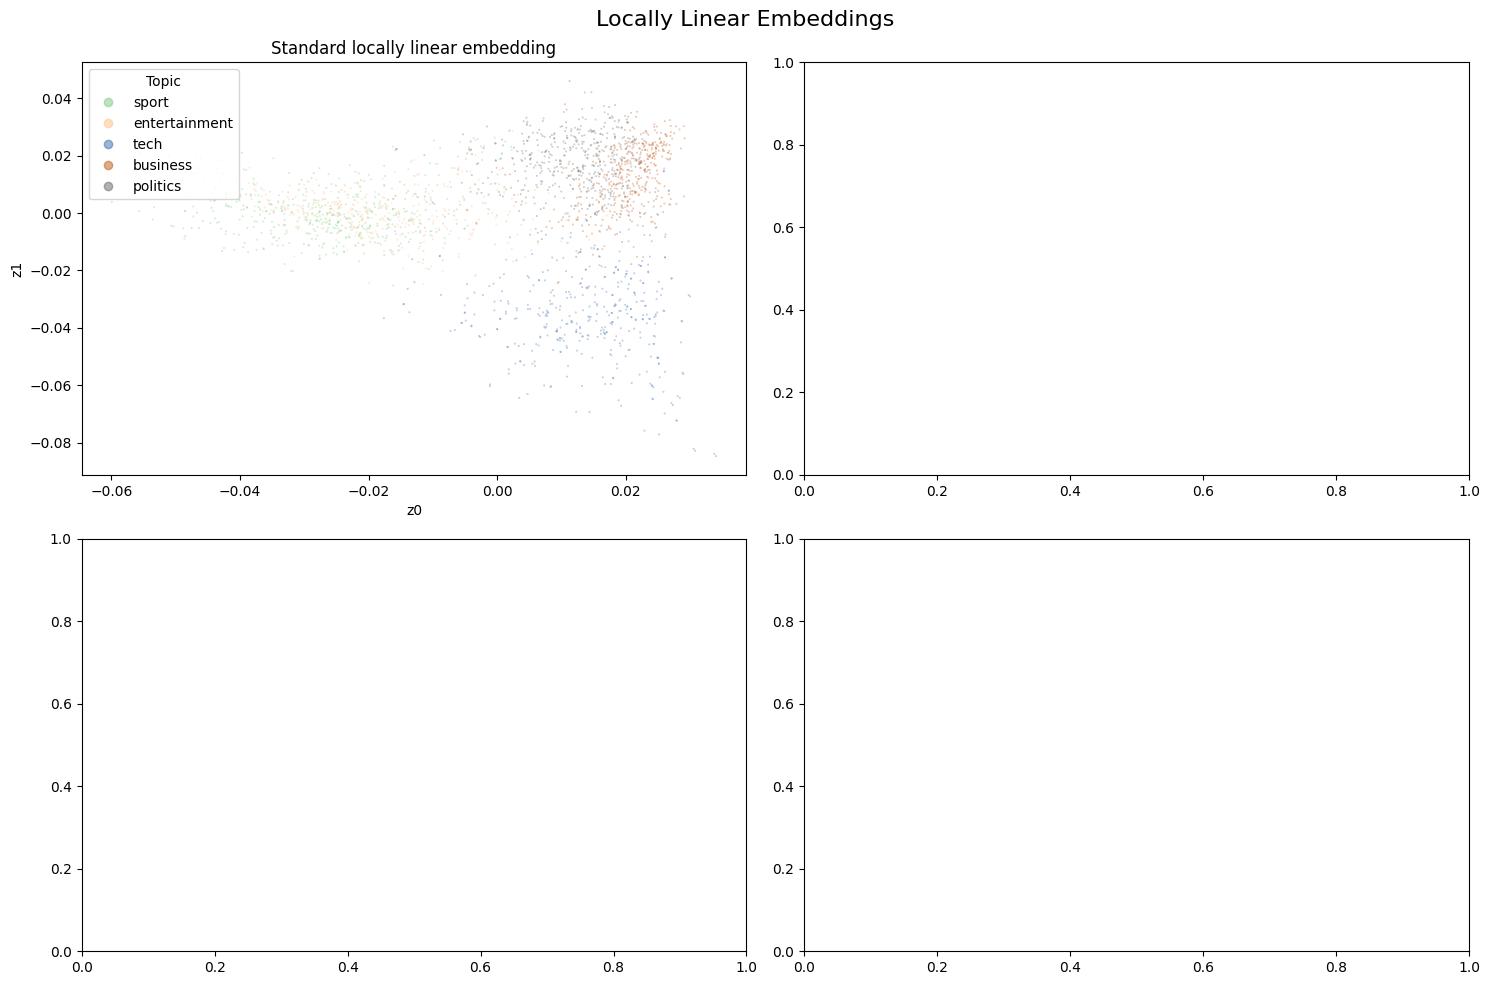

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [83]:
#fig, ax = plt.subplots()
nth_dims=(0, 1)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Locally Linear Embeddings", size=16)

for ax, method in zip(axs.flat, lle_methods):
    name, X_red = method
    points.plot2d(
        ax=ax,
        x=X_red[:, 0],
        y=X_red[:, 1],
        nth_dim=nth_dims,
        target_names=topics,
        target_idx_colors=topic_colors,
        t=name
    )
    
#ax.set_title('2D projection (random nb components) of the X (Word2Vec) matrix using t-SNE')

### Isomap Embedding

In [84]:
isomap = manifold.Isomap(
    n_neighbors=n_neighbors,
    n_components=n_components,
    p=1)
X_w2v_isomap = isomap.fit_transform(X_w2v)

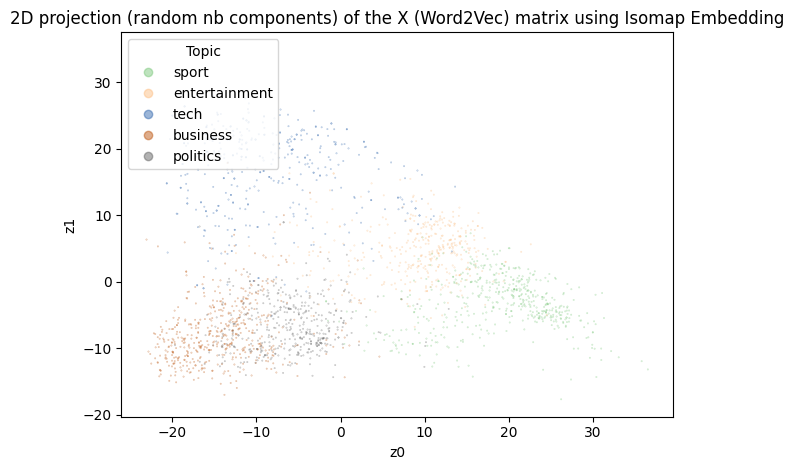

In [85]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_w2v_isomap[:, nth_dims[0]],
    y=X_w2v_isomap[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2Vec) matrix using Isomap Embedding'
)

### Multidimensional scaling

In [86]:
md_scaling = manifold.MDS(
    n_components=n_components,
    max_iter=2500,
    n_init=5,
    random_state=123,
    normalized_stress='auto',
)
X_w2v_scaling = md_scaling.fit_transform(X_w2v)


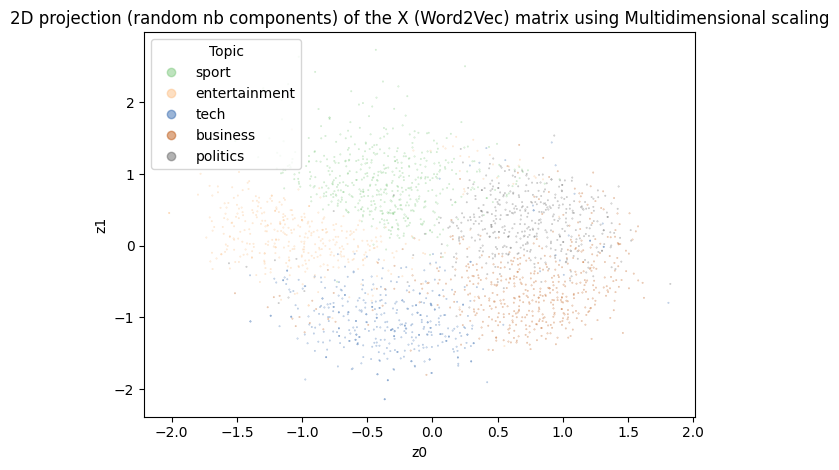

In [87]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_w2v_scaling[:, nth_dims[0]],
    y=X_w2v_scaling[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2Vec) matrix using Multidimensional scaling'
)

### Spectral embedding for non-linear dimensionality reduction

In [88]:
spectral4w2v = manifold.SpectralEmbedding(
    n_components=n_components,
    n_neighbors=n_neighbors
)
X_w2v_spectral = spectral4w2v.fit_transform(X_w2v)


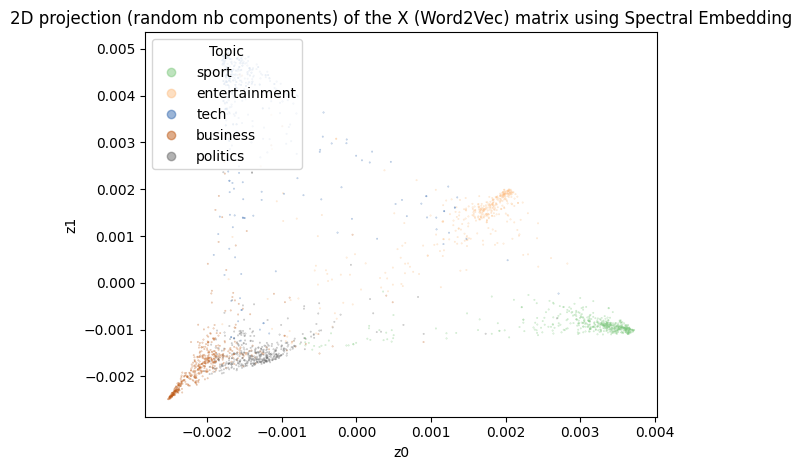

In [89]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_w2v_spectral[:, nth_dims[0]],
    y=X_w2v_spectral[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2Vec) matrix using Spectral Embedding'
)

### T-distributed Stochastic Neighbor Embedding

In [90]:
t_sne4w2v = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=2500,
    random_state=123,
)
X_w2v_t_sne = t_sne4w2v.fit_transform(X_w2v)

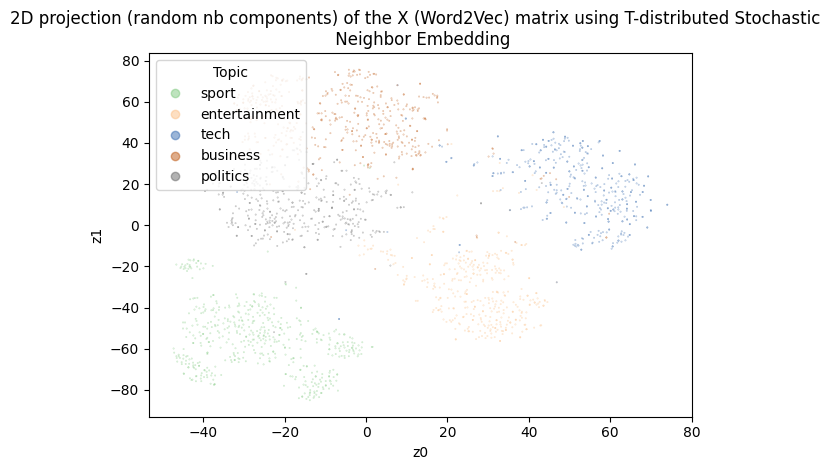

In [91]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_w2v_t_sne[:, nth_dims[0]],
    y=X_w2v_t_sne[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Word2Vec) matrix using T-distributed Stochastic  \n Neighbor Embedding'
)

On a une bonne représentation des données dans le sens où l'on peut identifier les groupe ou clustering

## <span style='color:#3390FF; font-weight: bold;'>GloVe representation of words</span>
---

### Principal Component Analysis 

In [92]:
# choix arbitraire
n_components = 2
pca = PCA(n_components=n_components)
X_glove_pca = pca.fit_transform(X_glove)

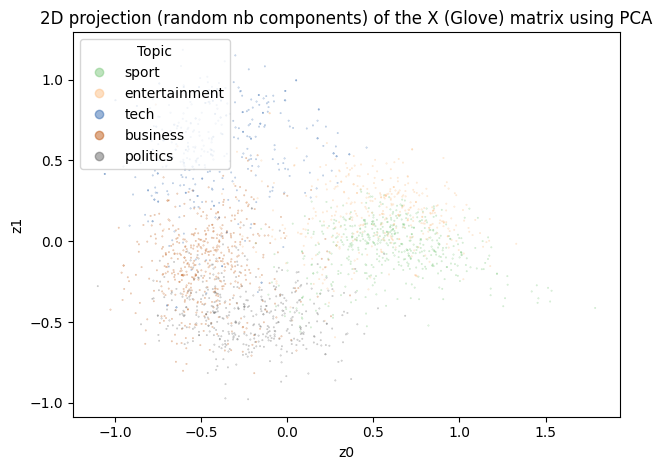

In [93]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_glove_pca[:, nth_dims[0]],
    y=X_glove_pca[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Glove) matrix using PCA'
)

#### $\rightarrow$ vers une approche T-SNE

In [94]:
t_sne4glove = TSNE(
    perplexity=40,
    n_components=2,
    init='pca',
    n_iter=2500,
    random_state=123
)
reduced_glove_tsne = t_sne4glove.fit_transform(X_glove)

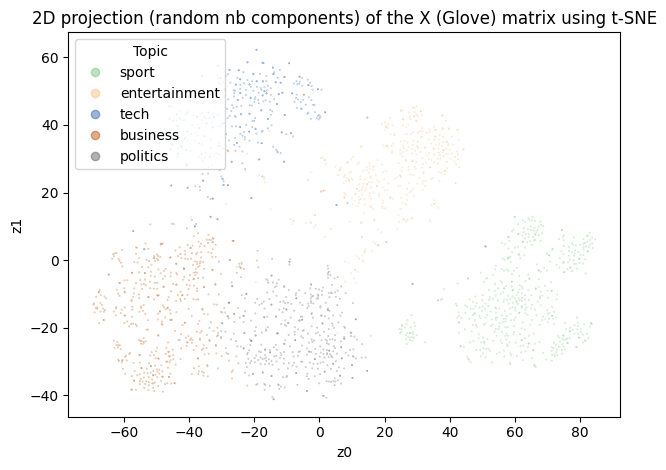

In [95]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=reduced_glove_tsne[:, nth_dims[0]],
    y=reduced_glove_tsne[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection (random nb components) of the X (Glove) matrix using t-SNE'
)

# <span style='color:green; font-weight: bold;'>Preparing Data frame For machine learning</span>

#### $\rightarrow$ dataframe
- Transformons $\mathbf{X}$ en dataframe où chaque ligne correspond à un document (ID en index) et chaque colonne correspond à un mot du vocabulaire (les mots en colonne).

In [96]:
# df_words = pd.DataFrame(
#    data = X,
#    columns = vocab,
#    index = df_text.index
#)
# df_words

# X_docs_bow => bow original (sparce) => not pca
# X_docs_bow_red_lsa => lsa reducted
# X_docs_bow_red_ipca => ipca reducted

# X_docs_tfidf => ifidf original (sparce) => not pca
# X_docs_tfidf_lsa => lsa reduced
# X_docs_tfidf_red_ipca => ipca reduced

In [97]:
df_words_bow = pd.DataFrame(
    data = X_docs_bow.toarray(), 
    index = df_bbc.index, 
    columns = bow_vectorizer.get_feature_names_out()
)
df_words_bow.head()


,000,000m,05,10,100,100m,102,104,10bn,10m,...,youngster,youth,yuan,yugansk,yuganskneftegas,yukos,zealand,zero,zone,zurich
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
df_words_tfidf = pd.DataFrame(
    data = X_docs_tfidf.toarray(),
    index = df_bbc.index,
    columns = tfidf_vectorizer.get_feature_names_out()
)
df_words_tfidf.head()


,00,000,000m,01,03,04,05,06,07,10,...,zach,zealand,zeppelin,zero,zhang,zimbabwe,zombie,zone,zoom,zurich
0,0.0,0.036688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066171,...,0.0,0.061951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115875
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


#### $\rightarrow$ dataframe(words-label)

- Jointure entre le dataframe obtenu et la colonne [topic].
- Faire le même nuage de points, cette fois-ci en coloriant les points par rapport à la thématique (colonne TOPIC).

In [99]:
df_bow = df_words_bow.merge(
    right = df_bbc.label,
    left_index = True,
    right_index=True
)
df_bow.head()

,000,000m,05,10,100,100m,102,104,10bn,10m,...,youth,yuan,yugansk,yuganskneftegas,yukos,zealand,zero,zone,zurich,label_y
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,sport
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,sport
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,sport
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,sport
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,sport


In [100]:
df_tfidf = df_words_tfidf.merge(
    right = df_bbc.label,
    left_index = True,
    right_index=True
)
df_tfidf.head()

,00,000,000m,01,03,04,05,06,07,10,...,zealand,zeppelin,zero,zhang,zimbabwe,zombie,zone,zoom,zurich,label_y
0,0.0,0.036688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,sport
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066171,...,0.061951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,sport
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,sport
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115875,sport
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,sport


# <span style='color:green; font-weight: bold;'>Approche Tandem : Réduction de la dimension à laquelle est ajoutée ensuite une tâche de clustering</span>
---

In [183]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import umap
import hdbscan # > sudo apt-get install python3.10-dev before

import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

## UMAP for Unsupervised Dimension Reduction and Traditional Clustering

#### Back-Of_Words X_matrix 

First, however, we’ll view the data (documents) colored by the topic that each data point represents – we’ll use a different color for each topics. This will help frame what follows.

In [102]:
X_docs_bow.shape

(2225, 5167)

In [121]:
%%time
X_docs_bow_umap_embedding_hlg = umap.UMAP(
    n_components=2,
    metric='hellinger'
).fit_transform(X_docs_bow)
X_docs_bow_umap_embedding.embedding_.shape


CPU times: user 31.6 s, sys: 839 ms, total: 32.4 s
Wall time: 14.1 s


(2225, 2)

In [104]:
%%time
X_docs_bow_umap_standard_embedding = umap.UMAP(random_state=42).fit_transform(X_docs_bow)
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

CPU times: user 9.32 s, sys: 950 ms, total: 10.3 s
Wall time: 8.83 s


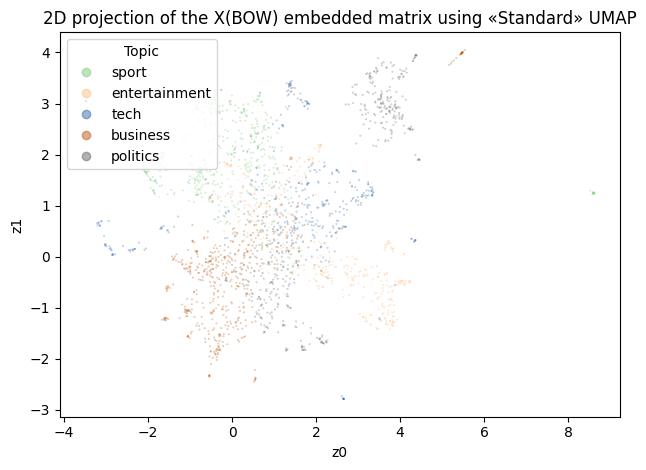

In [169]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_bow_umap_standard_embedding[:, nth_dims[0]],
    y=X_docs_bow_umap_standard_embedding[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection of the X(BOW) embedded matrix using «Standard» UMAP'
)

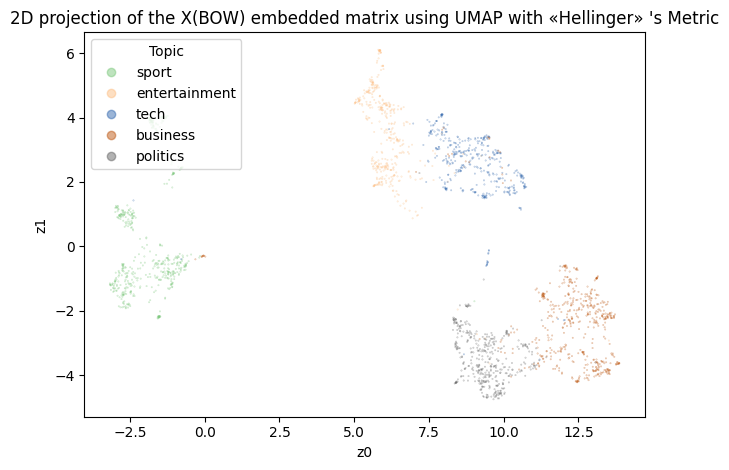

In [170]:
_, ax = plt.subplots()

nth_dims = (0, 1)
points.plot2d(
    ax=ax,
    x=X_docs_bow_umap_embedding_hlg[:, nth_dims[0]],
    y=X_docs_bow_umap_embedding_hlg[:, nth_dims[1]],
    nth_dim=nth_dims,
    target_names=topics,
    target_idx_colors=topic_colors,
    t='2D projection of the X(BOW) embedded matrix using UMAP with «Hellinger» \'s Metric'
)

Now we would like to cluster the data. As a first attempt let’s try the traditional approach: K-Means. In this case we can solve one of the hard problems for K-Means clustering – choosing the right k value, giving the number of clusters we are looking for. In this case we know the answer is exactly 10. We will use sklearns K-Means implementation looking for 10 clusters in the original 5167 dimensional data.

In [171]:
origin_kmeans_labels = cluster.KMeans(
    n_clusters=5,
    init='random',
    n_init=10
).fit_predict(df_words_bow)

In [166]:
umap_methods = [
    (
        "Original hellinger embedding",
        X_docs_bow_umap_embedding_hlg,
        topic_colors
    ),
    (
        "clustering hellinger version",
        X_docs_bow_umap_embedding_hlg,
        origin_kmeans_labels
    ),
]

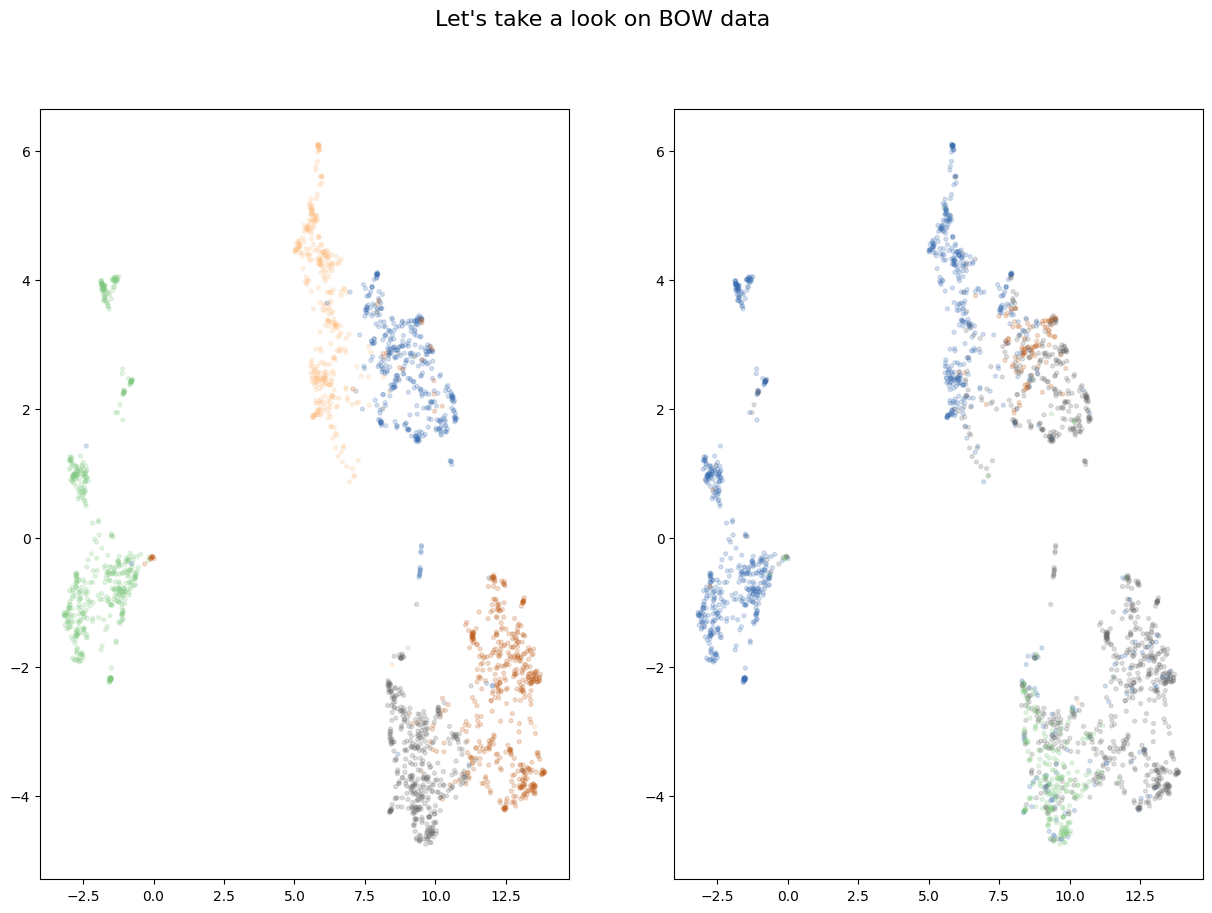

In [172]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
fig.suptitle("Let's take a look on BOW data", size=16)

nth_dims = (0, 1)
for ax, method in zip(axs.flat, umap_methods):
    name, X_red, c = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=c,
        s=8,
        cmap='Accent',
        alpha=0.2
    )

plt.show()

#### TF-IDF X_matrix 

First, however, we’ll view the data (documents) colored by the topic that each data point represents – we’ll use a different color for each topics. This will help frame what follows.

In [178]:
%%time
X_docs_tfidf_umap_embedding_hlg = umap.UMAP(n_components=2, metric='hellinger').fit_transform(X_docs_tfidf)
# X_docs_bow_umap_embedding.embedding_.shape
# fig = umap.plot.points(X_docs_tfidf_umap_embedding, labels=df_bbc['label'])

CPU times: user 26.5 s, sys: 800 ms, total: 27.3 s
Wall time: 16.6 s


In [179]:
%%time
X_docs_tfidf_umap_standard_embedding = umap.UMAP(random_state=42).fit_transform(X_docs_tfidf)
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

CPU times: user 3.13 s, sys: 631 ms, total: 3.76 s
Wall time: 2.51 s


Now we would like to cluster the data. As a first attempt let’s try the traditional approach: K-Means. In this case we can solve one of the hard problems for K-Means clustering – choosing the right k value, giving the number of clusters we are looking for. In this case we know the answer is exactly 10. We will use sklearns K-Means implementation looking for 10 clusters in the original 5167 dimensional data.

In [180]:
origin_tfidf_kmeans_labels = cluster.KMeans(
    n_clusters=5,
    init='random',
    n_init=10
).fit_predict(df_words_tfidf)

In [181]:
umap_methods = [
    (
        "Original hellinger embedding",
        X_docs_tfidf_umap_embedding_hlg,
        topic_colors
    ),
    (
        "clustering hellinger version",
        X_docs_tfidf_umap_embedding_hlg,
        origin_tfidf_kmeans_labels
    ),
]

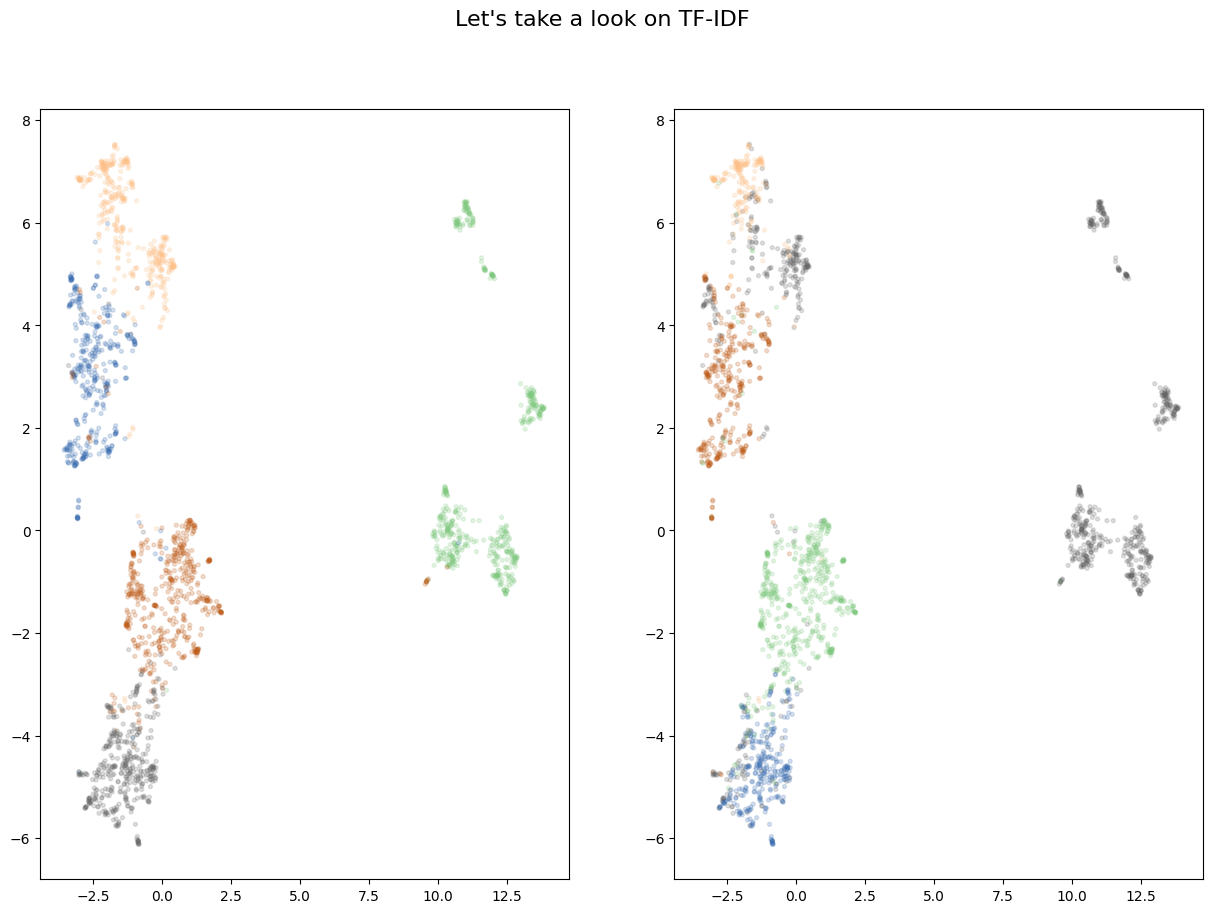

In [182]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
fig.suptitle("Let's take a look on TF-IDF", size=16)

nth_dims = (0, 1)
for ax, method in zip(axs.flat, umap_methods):
    name, X_red, c = method
    scatter = ax.scatter(
        x=X_red[:, 0],
        y=X_red[:, 1],
        c=c,
        s=8,
        cmap='Accent',
        alpha=0.2
    )

plt.show()

In [186]:
(
    adjusted_rand_score(
        df_words_tfidf.target,
        origin_tfidf_kmeans_labels
    ),
    adjusted_mutual_info_score(
        df_words_tfidf.target,
        origin_tfidf_kmeans_labels
    )
)

/home/godwin/.cache/pypoetry/virtualenvs/dsa-MQpLTWhO-py3.10/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/home/godwin/.cache/pypoetry/virtualenvs/dsa-MQpLTWhO-py3.10/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


(0.010481900180074622, 0.008746023868480909)